## Utils

In [4]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output


import numpy as np 
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

In [5]:
i2action = {
    0:'left',
    1:'down',
    2:'right',
    3:'up'
}

In [430]:
def evaluate_policy(env, q_values, policy_method, gamma=1.0, n=100):
    rewards = []
    for _ in range(n):
        state = env.reset()[0]
        total_reward = 0
        done = False
        while not done:
            action = policy_method(q_values, state)
            state, reward, done, _, _ = env.step(action)

            total_reward += reward
        rewards.append(total_reward)

    return np.mean(rewards)

def print_policy(q_values):
    n = env.action_space.n
    policy = np.array(np.argmax(q_values, axis=1)).reshape(n, n)
    policy_txt = np.chararray((n, n), 10)
    for i in range(n):
        for j in range(n):
            policy_txt[i][j] = i2action[policy[i][j]]
    print(policy_txt)
    
def print_policy_to_action(policy):
    n = env.action_space.n
    # policy = np.array(np.argmax(q_values, axis=1)).reshape(n, n)
    policy_txt = np.chararray((n, n), 10)
    for i in range(n):
        for j in range(n):
            policy_txt[i][j] = i2action[policy[i * n + j]]
    print(policy_txt)

## FrozenLake

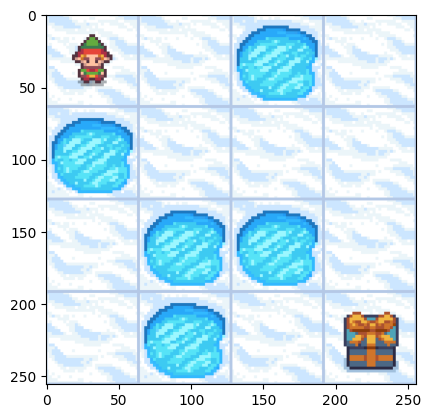

In [369]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array", desc=generate_random_map(size=4), is_slippery=False)
env.reset()
plt.imshow(env.render())

## Q-learning

In [363]:
def e_greedy_policy(q_values, state, eps=0.2):
    rand = np.random.rand()
    if rand < eps:
        return env.action_space.sample()
    else:
        return np.argmax(q_values[state])

def greedy_policy(q_values, state):
    return np.argmax(q_values[state])    

def q_learning(
    env,
    policy_method,
    episode_num=1000,
    gamma=1.0,
    alpha=0.1,
    eps=0.2
):
    q_values = np.zeros(shape=(env.observation_space.n, env.action_space.n)) 

    scores = []
    for _ in tqdm(range(episode_num)):

        state = env.reset()[0]
        done = False
        step_i = 1
        while not done:
            action = policy_method(q_values, state)

            new_state, reward, done, _, p = env.step(action)
            
            prob = p["prob"]
            discount_factor = gamma ** step_i
            q_values[state, action] += alpha * (reward + discount_factor * np.max(q_values[new_state]) - q_values[state, action])
            state = new_state
            step_i += 1

        score = evaluate_policy(env, q_values, policy_method, n=1)
        scores.append(score)

    return q_values, scores

100%|██████████| 10000/10000 [00:03<00:00, 2774.56it/s]


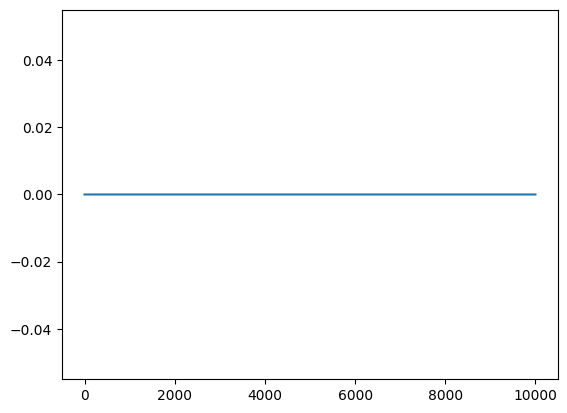

In [372]:
q_values, scores = q_learning(env, e_greedy_policy, episode_num=10000, gamma=0.9, alpha=0.1, eps=0.5)

plt.plot(scores);

[[b'left' b'left' b'left' b'left']
 [b'left' b'left' b'left' b'left']
 [b'left' b'left' b'left' b'left']
 [b'left' b'left' b'left' b'left']]


/var/folders/3h/dhhfcbhd3pl2ss8czvd22c080000gn/T/ipykernel_41055/3623696364.py:19: DeprecationWarning: `np.chararray` is deprecated and will be removed from the main namespace in the future. Use an array with a string or bytes dtype instead.
  policy_txt = np.chararray((n, n), 10)


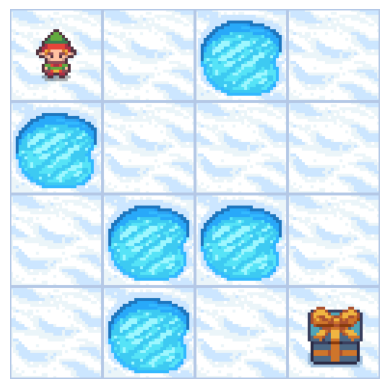

In [405]:
env.reset()
print_policy(q_values);
plt.imshow(env.render());
plt.axis("off");

# Policy iteration

In [479]:
def evaluate_policy(env, policy, gamma, n=100):
    scores = []
    for _ in tqdm(range(n)):
        obs = env.reset()[0]
        total_reward = 0
        step_idx = 0
        done = False
        while not done:
            obs, reward, done , _, _ = env.step(int(policy[obs]))

            total_reward += (gamma ** step_idx * reward)
            step_idx += 1
            if step_idx > 50:
                break
        scores.append(total_reward)
    
    return np.mean(scores)

In [480]:
def extract_policy(v, gamma = 1.0, alpha = 0.9):
    """
    Get new policy according to max Q-func for each state.
    """
    policy = np.zeros(env.observation_space.n)
    q = np.zeros((env.observation_space.n, env.action_space.n))
    for state in env.get_wrapper_attr('P').keys():
        for a in env.get_wrapper_attr('P')[state].keys():
            q_old = q[state, a]
            q[state, a] = np.sum(
                [(1 - alpha) * q_old + alpha * p * (r + gamma * v[s]) for p, s, r, _ in env.get_wrapper_attr('P')[state][a]]
            )
        policy[state] = np.argmax(q[state, :])
    return policy

In [481]:
def compute_policy_v(env, policy, gamma=1.0):
    """
    Compute V - func for all states for current policy.
    """
    v_cur = np.zeros(env.observation_space.n)
    while True:
        v_prev = v_cur.copy()
        for state in range(env.observation_space.n):
            # Value of state = sum of values of all possible next states
            v_cur[state] = np.sum(
                [p * (r + gamma * v_prev[s]) for p, s, r, _ in env.get_wrapper_attr('P')[state][policy[state]]]
            )
        # If V - func converges
        if np.linalg.norm(v_cur - v_prev) < 1e-10:
            break
    return v_cur

In [482]:
def policy_iteration(env, gamma = 1.0, iteration_num = 100):
    policy = np.random.choice(np.arange(env.action_space.n), env.observation_space.n)
    scores = []

    for _ in tqdm(range(iteration_num)):
        old_policy_v = compute_policy_v(env, policy, gamma)
        new_policy = extract_policy(old_policy_v, gamma)

        # If new policy hasn't improved
        if (np.all(policy == new_policy)):
            break

        policy = new_policy
        
        score = evaluate_policy(env, policy, gamma = 0.9, n = 100)
        scores.append(score)
        
        
    return policy, scores

In [483]:
p, scores = policy_iteration(env, gamma=0.9, iteration_num=1000)

  1%|          | 6/1000 [00:00<00:37, 26.69it/s]


In [484]:
scores

[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.5904900000000002)]

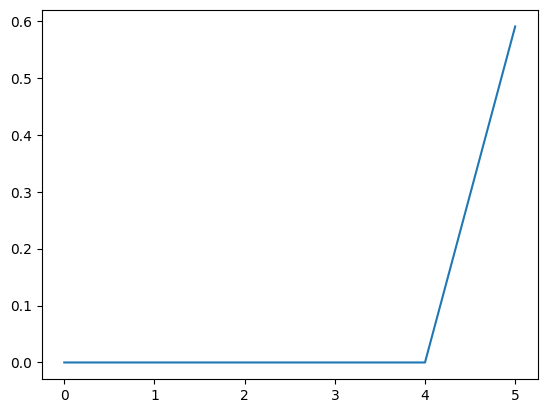

In [485]:
plt.plot(scores);

In [486]:
evaluate_policy(env, p, gamma=1, n=100)

100%|██████████| 100/100 [00:00<00:00, 10333.60it/s]


np.float64(1.0)

In [456]:
print_policy_to_action(p)

[[b'right' b'down' b'left' b'down']
 [b'left' b'right' b'right' b'down']
 [b'left' b'left' b'left' b'down']
 [b'left' b'left' b'right' b'left']]


/var/folders/3h/dhhfcbhd3pl2ss8czvd22c080000gn/T/ipykernel_41055/727328936.py:28: DeprecationWarning: `np.chararray` is deprecated and will be removed from the main namespace in the future. Use an array with a string or bytes dtype instead.
  policy_txt = np.chararray((n, n), 10)


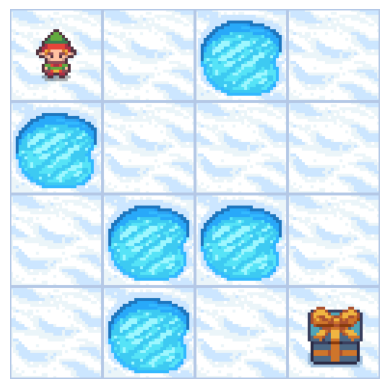

In [457]:
env.reset()
plt.imshow(env.render());
plt.axis("off");